# A Synthetic Building Operation Data

***Prepared by:*** [**Han Li**](https://github.com/tsbyq)

This notebook explores the synthetic building operation dataset generated from simulations with U.S. DOE reference detailed medium-sized office building. 
We demonstrate the basic data extraction and visualization, as well as example use cases of the data.


In [1]:
# Libraries used in this notebook
import pandas as pd
import numpy as np
import h5py
import os
import datetime
from matplotlib import pyplot as plt 
import seaborn as sns
import s3fs

In [2]:
# Converting factors
J_to_kWh = 1/3600000
area = 4982.22 # m2
kBtu_to_kWh = 0.293071
ft2_to_m2 = 0.092903
kBtu_per_ft2_to_kWh_per_m2 = kBtu_to_kWh/ft2_to_m2

In [23]:
# Utility functions
def get_df_from_hdf(hdf, climate='1A', efficiency='High', year='TMY3', str_run='run_1', data_key='ZonePeopleOccupantCount'):
    '''
    This function extracts the dataframe from the all run hdf5 file
    '''
    ts_root = hdf.get('3. Data').get('3.2. Timeseries')
    sub = ts_root.get(climate).get(efficiency).get(year).get(str_run).get(data_key)
    cols = np.array(sub.get('axis0'))[1:].astype(str)
    data = np.array(sub.get('block1_values'))
    df = pd.DataFrame(data, columns = cols)
    df.index = [ts.strftime('%Y-%m-%d %H:%M:%S') for ts in pd.date_range('2006-01-01', '2007-01-01', freq='10min')[:-1]]
    return df

def ls_to_text_file(ls_lines, dir_txt_out, decode='UTF-8'):
    '''
    This function writes a list of strings to a text file
    '''
    with open(dir_txt_out, 'w') as filehandle:
        for line in ls_lines:
            filehandle.write(line.decode(decode))
        filehandle.close()

        
def get_monthly_sum(hdf, str_clm, str_eff, str_yr, str_run, var='ElectricityFacility', convert=J_to_kWh):
    '''
    This function calculates the monthly sum of a specific variable from a yearly simulation
    '''
    df = get_df_from_hdf(
        hdf, 
        str_clm, 
        str_eff, 
        str_yr, 
        str_run, 
        var
    )
    df['datetime'] = pd.to_datetime(df.index)
    df = df.reset_index(drop=True)
    df['month'] = df['datetime'].dt.month
    df_temp = df.groupby('month').sum()*J_to_kWh
    return np.array(df_temp.iloc[:, 0])
        
        
def get_all_monthly_site_energy(hdf, str_clm, str_eff):
    '''
    This function getd the monthly site energy consumptions for all simulations in for a specific climate and efficiency level
    '''
    ts_root = hdf.get('3. Data').get('3.2. Timeseries')
    dict_all_years = {}
    ls_yrs = list(ts_root.get(str_clm).get(str_eff).keys())
    for str_yr in ls_yrs:
        ls_runs = list(ts_root.get(str_clm).get(str_eff).get(str_yr).keys())  
        for i, str_run in enumerate(ls_runs):
            if i == 0:
                arr_monthly_sums = get_monthly_sum(hdf, str_clm, str_eff, str_yr, str_run, 'ElectricityFacility') + get_monthly_sum(hdf, str_clm, str_eff, str_yr, str_run, 'GasFacility')
            else:
                arr_monthly_sums += get_monthly_sum(hdf, str_clm, str_eff, str_yr, str_run, 'ElectricityFacility') + get_monthly_sum(hdf, str_clm, str_eff, str_yr, str_run, 'GasFacility')
        dict_all_years[str_yr] = (arr_monthly_sums/5)
    return dict_all_years


def get_all_weather(str_clm, hdf, start_year):
    '''
    This function gets the outdoor air temperature data for all years of the specific climate zone starting from a certain year.
    '''
    str_eff = 'Standard'
    str_run = 'run_1'
    count = 0
    ts_root = hdf.get('3. Data').get('3.2. Timeseries')
    ls_yrs = list(ts_root.get(str_clm).get(str_eff).keys())
    for str_yr in ls_yrs:
        if str_yr != 'TMY3':
            dd = get_df_from_hdf(hdf, str_clm, str_eff, str_yr, str_run, 'SiteOutdoorAirDrybulbTemperature')
            if count == 0:
                arr_all_t = dd.to_numpy()
            else:
                arr_all_t = np.concatenate((arr_all_t, dd.to_numpy()), axis=0)
        count += 1
    df_all_OAT = pd.DataFrame(arr_all_t, 
                              columns=['OAT'], 
                              index=pd.date_range(f'{start_year}-01-01', periods=1576800, freq='10Min'))
    df_all_OAT['datetime'] = df_all_OAT.index
    df_all_OAT['month'] = df_all_OAT['datetime'].dt.strftime('%Y-%m')
    return df_all_OAT


def get_ts_data(hdf, str_clm = '5A', str_eff = 'Standard', str_yr = '1992', str_run = 'run_1'):
    '''
    This function extracts the time series data from the HDF5 file
    '''
    ts_root = hdf.get('3. Data').get('3.2. Timeseries')
    ts_root.get(str_clm).get(str_eff).get(str_yr).get(str_run).keys()
    df_oat = get_df_from_hdf(hdf, str_clm, str_eff, str_yr, str_run, 'SiteOutdoorAirDrybulbTemperature')
    df_ele = get_df_from_hdf(hdf, str_clm, str_eff, str_yr, str_run, 'ElectricityFacility')
    df_mels = get_df_from_hdf(hdf, str_clm, str_eff, str_yr, str_run, 'InteriorEquipmentElectricity')
    df_lights = get_df_from_hdf(hdf, str_clm, str_eff, str_yr, str_run, 'InteriorLightsElectricity')
    df_occs = pd.DataFrame(get_df_from_hdf(hdf, str_clm, str_eff, str_yr, str_run, 'ZonePeopleOccupantCount').sum(axis=1), columns=['Total Occupant Count'])
    df_havc_ele = get_df_from_hdf(hdf, str_clm, str_eff, str_yr, str_run, 'ElectricityHVAC')
    df_gas = get_df_from_hdf(hdf, str_clm, str_eff, str_yr, str_run, 'GasFacility')
    
    df_col = pd.concat([df_occs, df_lights, df_mels, df_ele, df_gas, df_havc_ele, df_oat], axis=1)
    df_col['datetime'] = pd.to_datetime(df_col.index)
    df_col['climate'] = str_clm
    df_col['efficiency'] = str_eff
    df_col['weekday'] = np.where(df_col['datetime'].dt.dayofweek < 5, True, False)
    df_col['Interior Lighting (kWh)'] = df_col['InteriorLights:Electricity[J]'] * J_to_kWh
    df_col['MELs (kWh)'] = df_col['InteriorEquipment:Electricity[J]'] * J_to_kWh
    df_col['Site Electricity (kWh)'] = df_col['Electricity:Facility[J]'] * J_to_kWh
    df_col['Site Gas (kWh)'] = df_col['Gas:Facility[J]']* J_to_kWh
    df_col['Site Total Energy (kWh)'] = df_col['Site Electricity (kWh)'] + df_col['Site Gas (kWh)']
    df_col['HVAC Electricity (kWh)'] = df_col['Electricity:HVAC[J]'] * J_to_kWh
    df_col['Outdoor Air Temperature (degC)'] = df_col['Environment:Site Outdoor Air Drybulb Temperature[C]']
    df_col = df_col.drop(['InteriorLights:Electricity[J]', 
                          'InteriorEquipment:Electricity[J]', 
                          'Electricity:Facility[J]',
                          'Gas:Facility[J]',
                          'Environment:Site Outdoor Air Drybulb Temperature[C]'
                         ], axis=1)
    df_col['Operating Time'] = np.where(
        (df_col['datetime'].dt.hour > 6) & 
        (df_col['datetime'].dt.hour < 20) &
        (df_col['weekday'] == True), 'Yes', 'No')
    df_col['hour'] = df_col['datetime'].dt.hour
    return df_col


In [4]:
# Dataset structure
print('This HDF file contains a "1. README" file and a "2. Resources" folder, and a "3. Data" folder.')
print('The "2. Resources" folder contains "2.1. Building Models" and "2.2. Weather Files".')
print('The "3. Data" folder contains "3.1. Metadata" and "3.2. Timeseries".')

This HDF file contains a "1. README" file and a "2. Resources" folder, and a "3. Data" folder.
The "2. Resources" folder contains "2.1. Building Models" and "2.2. Weather Files".
The "3. Data" folder contains "3.1. Metadata" and "3.2. Timeseries".


## Access the data

In [5]:
# Open a HDF file
dir_to_HDF = '<path_to_the_file>' 
hdf = h5py.File(dir_to_HDF, 'r')

# Access the HDF5 file from AWS S3 bucket
dir_aws_s3 = 's3://oedi-data-lake/building_synthetic_dataset/A_Synthetic_Building_Operation_Dataset.h5'
s3 = s3fs.S3FileSystem()
hdf = h5py.File(s3.open(dir_aws_s3, "rb"))

In [6]:
# Read resources files from the HDF and write them to files

dir_to_file = '' # replace this to your desired output path
# Read seed models
print('- ' * 30)
print('The seed models are:')
for key_model in hdf.get('2. Resources').get('2.1. Building Models').keys():
    print(key_model)

# e.g., Write the model for climate zone 5A with high efficiency level.
lines = hdf.get('2. Resources').get('2.1. Building Models').get('MediumOfficeDetailed_90.1-2013_5A_High_efficiency.osm')
# ls_to_text_file(lines, os.path.join(dir_to_file, 'model.osm'))

print('- ' * 30)
print('The weather files are for ASHRAE climates:')
for key_model in hdf.get('2. Resources').get('2.2. Weather Files').keys():
    print(key_model)

# e.g., Write a single year's weather file of climate 1A to epw file
lines = hdf.get('2. Resources').get('2.2. Weather Files').get('1A').get('Miami_2005.epw')
# ls_to_text_file(lines, os.path.join(dir_to_file, 'weather.epw'))

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
The seed models are:
MediumOfficeDetailed_90.1-2013_1A_High_efficiency.osm
MediumOfficeDetailed_90.1-2013_1A_Low_efficiency.osm
MediumOfficeDetailed_90.1-2013_1A_Standard_efficiency.osm
MediumOfficeDetailed_90.1-2013_3C_High_efficiency.osm
MediumOfficeDetailed_90.1-2013_3C_Low_efficiency.osm
MediumOfficeDetailed_90.1-2013_3C_Standard_efficiency.osm
MediumOfficeDetailed_90.1-2013_5A_High_efficiency.osm
MediumOfficeDetailed_90.1-2013_5A_Low_efficiency.osm
MediumOfficeDetailed_90.1-2013_5A_Standard_efficiency.osm
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
The weather files are for ASHRAE climates:
1A
3C
5A


In [7]:
# Read the metadata, and write them to a local TTL file for inspection

lines = hdf.get('3. Data').get('3.1. Metadata').get('brick_relationhsips.ttl')
dir_to_file = '' # replace this to your desired output path
ls_to_text_file(lines, os.path.join(dir_to_file, 'brick_relationhsips.ttl'))


In [8]:
# Read the time-series data into a Pandas dataframe

# list all the variables of a single simulation
ls_variables = list(hdf.get('3. Data').get('3.2. Timeseries').get('1A').get('Standard').get('TMY3').get('run_1').keys())

# get the variables in Pandas dataframe for a specific run
str_climate = '1A'
str_efficiency = 'Standard'
str_year = '2000'
str_run = 'run_1'
str_var = 'ElectricityFacility'

df_example_1 = get_df_from_hdf(
    hdf=hdf, 
    climate=str_climate, 
    efficiency=str_efficiency, 
    year=str_year, 
    str_run=str_run, 
    data_key=str_var
)

df_example_1.describe()

,Electricity:Facility[J]
count,5.256000e+04
mean,4.531469e+07
std,2.905393e+07
min,5.799975e+06
25%,1.844440e+07
50%,3.514069e+07
75%,7.354144e+07
max,1.159792e+08


## Explore the data

#### Monhtly site energy consumption

In [9]:
# Get the monthly site energy consumption for all simulations in a dictionary
ls_climates = ['1A', '3C', '5A']
ls_effs = ['High', 'Standard', 'Low']

dict_monthly_kWh = {}
for str_clm in ls_climates:
    for str_eff in ls_effs:
        dict_monthly_kWh[f'{str_clm}_{str_eff}'] = get_all_monthly_site_energy(hdf, str_clm, str_eff)


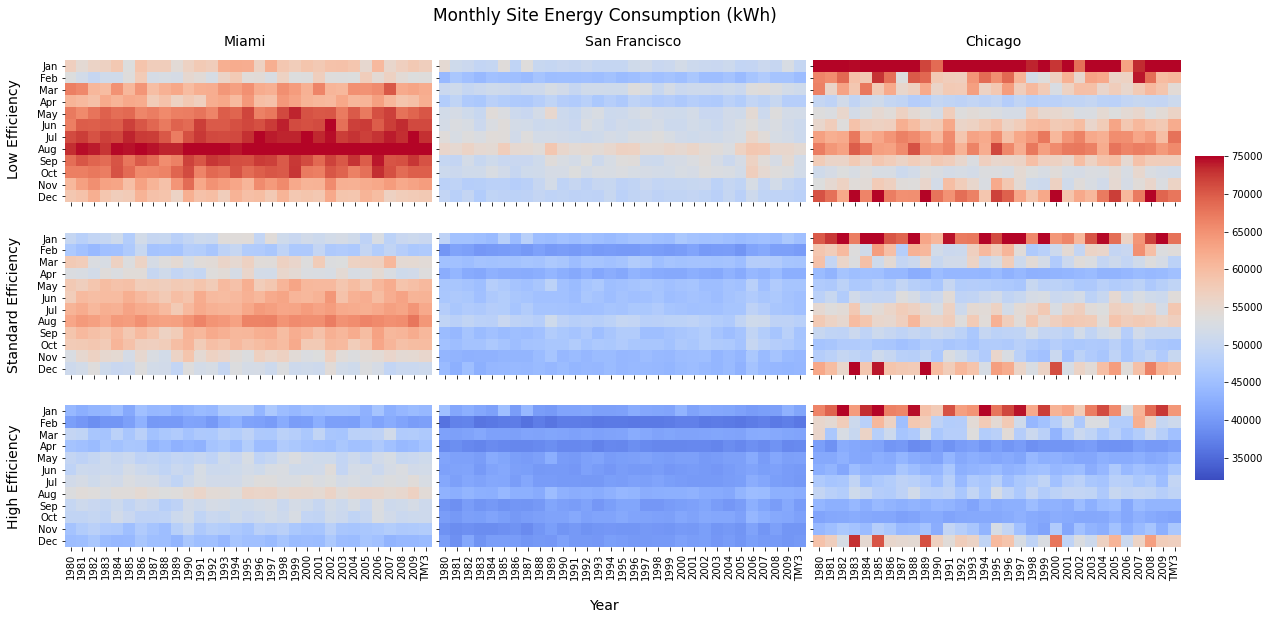

In [10]:
ls_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig, axes = plt.subplots(3, 3, figsize=(20, 9), sharex=True, sharey=True)
cbar_ax = fig.add_axes([0.91,0.25,0.02,0.5])

sns.heatmap(pd.DataFrame(dict_monthly_kWh['1A_Low'], index=ls_months), ax=axes[0][0], cmap='coolwarm', square=True, vmin=32000, vmax=75000, cbar=False, cbar_ax=None)
sns.heatmap(pd.DataFrame(dict_monthly_kWh['1A_Standard'], index=ls_months), ax=axes[1][0], cmap='coolwarm', square=True, vmin=32000, vmax=75000, cbar=False, cbar_ax=cbar_ax)
sns.heatmap(pd.DataFrame(dict_monthly_kWh['1A_High'], index=ls_months), ax=axes[2][0], cmap='coolwarm', square=True, vmin=32000, vmax=75000, cbar=False, cbar_ax=None)
sns.heatmap(pd.DataFrame(dict_monthly_kWh['3C_Low'], index=ls_months), ax=axes[0][1], cmap='coolwarm', square=True, vmin=32000, vmax=75000, cbar=False, cbar_ax=None)
sns.heatmap(pd.DataFrame(dict_monthly_kWh['3C_Standard'], index=ls_months), ax=axes[1][1], cmap='coolwarm', square=True, vmin=32000, vmax=75000, cbar=True, cbar_ax=cbar_ax)
sns.heatmap(pd.DataFrame(dict_monthly_kWh['3C_High'], index=ls_months), ax=axes[2][1], cmap='coolwarm', square=True, vmin=32000, vmax=75000, cbar=False, cbar_ax=None)
sns.heatmap(pd.DataFrame(dict_monthly_kWh['5A_Low'], index=ls_months), ax=axes[0][2], cmap='coolwarm', square=True, vmin=32000, vmax=75000, cbar=False, cbar_ax=None)
sns.heatmap(pd.DataFrame(dict_monthly_kWh['5A_Standard'], index=ls_months), ax=axes[1][2], cmap='coolwarm', square=True, vmin=32000, vmax=75000, cbar=False, cbar_ax=cbar_ax)
sns.heatmap(pd.DataFrame(dict_monthly_kWh['5A_High'], index=ls_months), ax=axes[2][2], cmap='coolwarm', square=True, vmin=32000, vmax=75000, cbar=False, cbar_ax=None)

fig.suptitle('Monthly Site Energy Consumption (kWh)', size=17)

fig.text(0.5, 0.05, 'Year', ha='center', size=14)
fig.text(0.25, 0.92, 'Miami', ha='center', size=14)
fig.text(0.52, 0.92, 'San Francisco', ha='center', size=14)
fig.text(0.77, 0.92, 'Chicago', ha='center', size=14)
fig.text(0.09, 0.72, 'Low Efficiency', ha='center', rotation=90, size=14)
fig.text(0.09, 0.42, 'Standard Efficiency', ha='center', rotation=90, size=14)
fig.text(0.09, 0.18, 'High Efficiency', ha='center', rotation=90, size=14)

fig.subplots_adjust(top=0.92, hspace=0.01, wspace=0.02)

# fig.savefig('kWh-all.png', dpi=800)

#### Outdoor air temperature

In [12]:
# Get all weather data
df_all_OAT_1A = get_all_weather('1A', hdf, 1976)
df_all_OAT_3C = get_all_weather('3C', hdf, 1988)
df_all_OAT_5A = get_all_weather('5A', hdf, 1980)


Text(0.5, 0.98, 'Historical Outdoor Air Temperature (degC)')

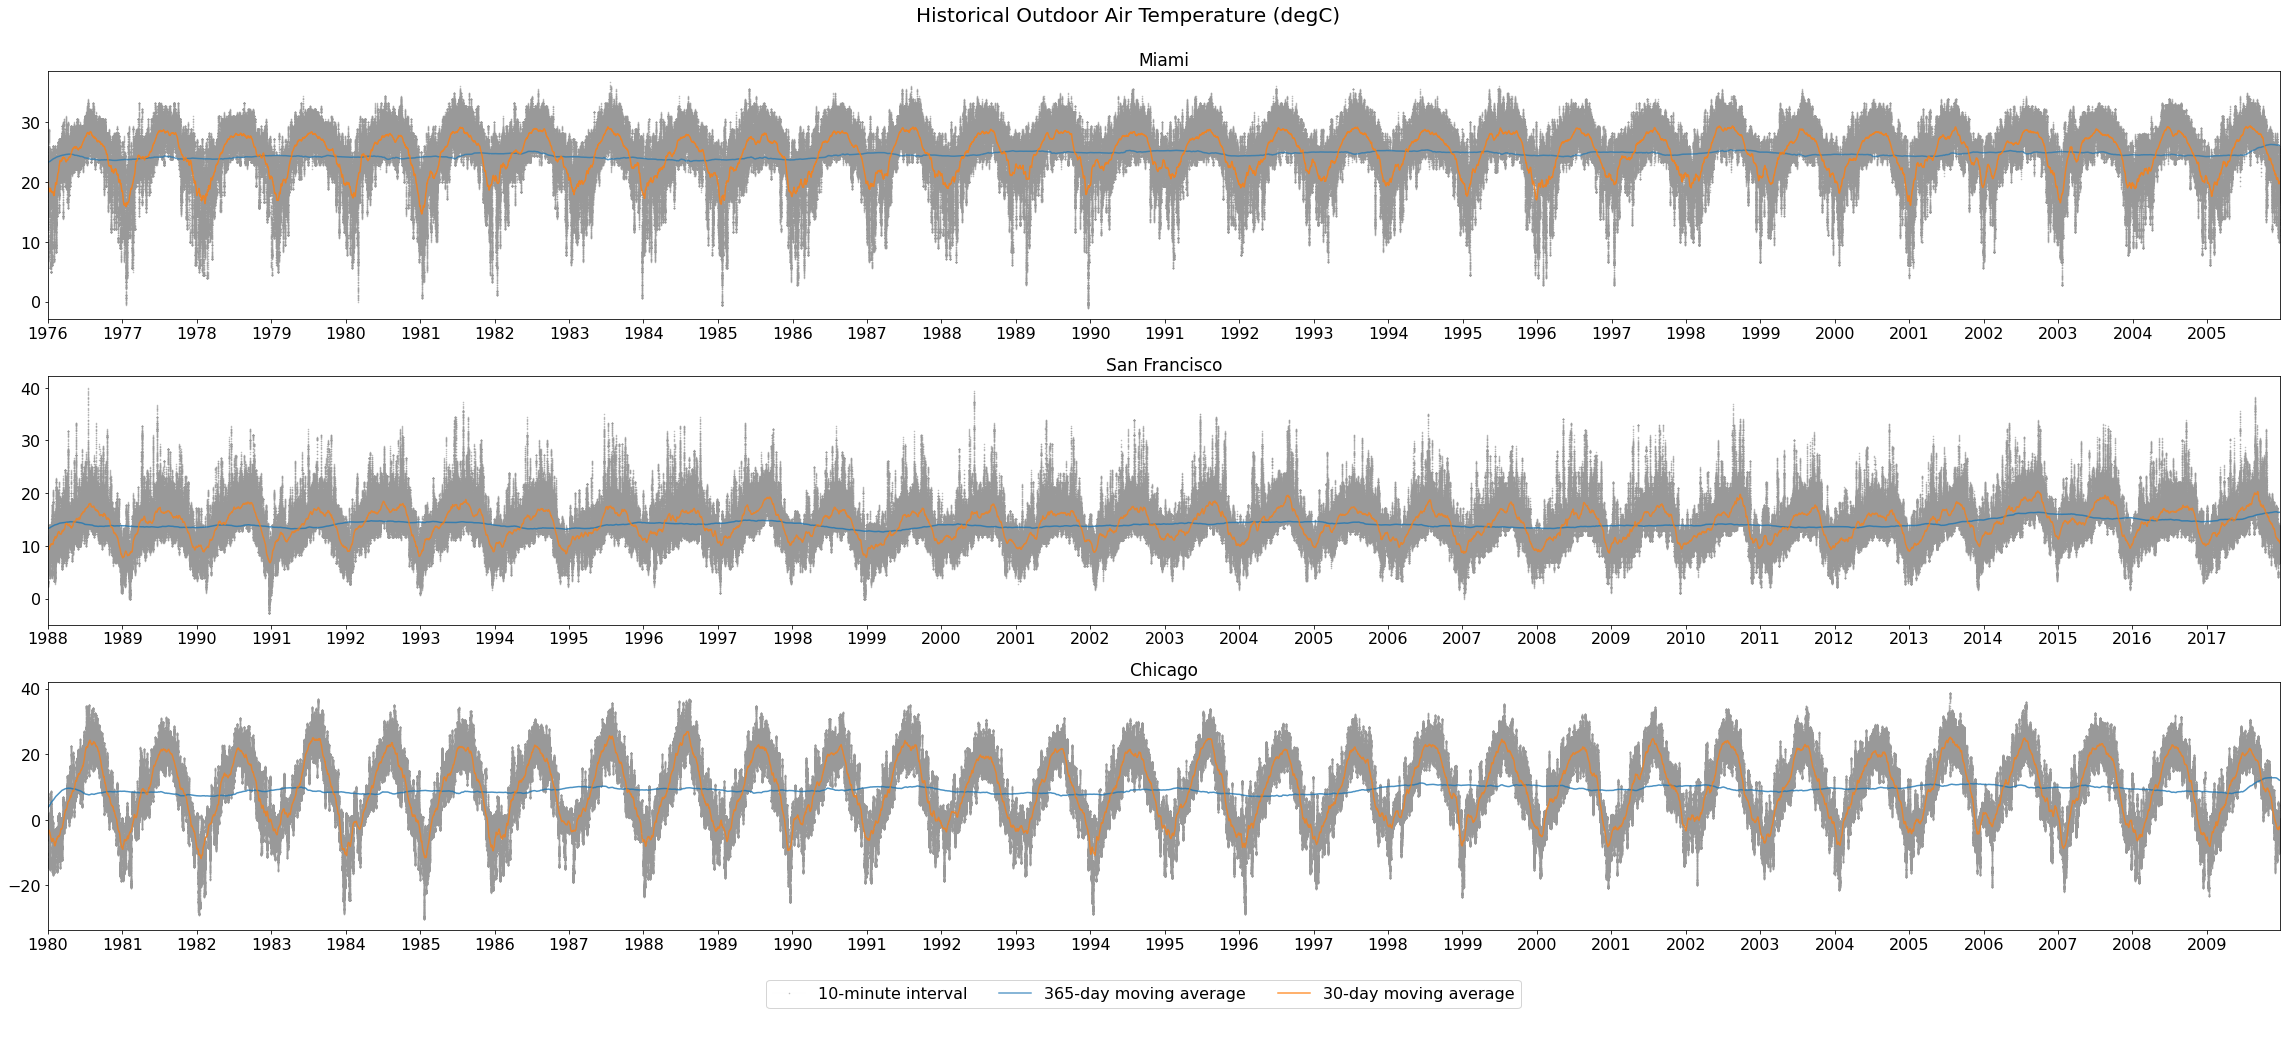

In [13]:
import matplotlib.dates as mdates

hist_range = (0, 300) # For total eui
# hist_range = (0, 15) # For natural gas eui


fig, axes = plt.subplots(3, 1,figsize=(40, 15))

# Plot the weather data
arr_raw_1A = df_all_OAT_1A['OAT']
arr_annuaul_moving_avg_1A = df_all_OAT_1A['OAT'].rolling(window=52560, center=True, min_periods=360).mean()
arr_30d_moving_avg_1A = df_all_OAT_1A['OAT'].rolling(window=4320, center=True, min_periods=360).mean()
arr_raw_3C = df_all_OAT_3C['OAT']
arr_annuaul_moving_avg_3C = df_all_OAT_3C['OAT'].rolling(window=52560, center=True, min_periods=360).mean()
arr_30d_moving_avg_3C = df_all_OAT_3C['OAT'].rolling(window=4320, center=True, min_periods=360).mean()
arr_raw_5A = df_all_OAT_5A['OAT']
arr_annuaul_moving_avg_5A = df_all_OAT_5A['OAT'].rolling(window=52560, center=True, min_periods=360).mean()
arr_30d_moving_avg_5A = df_all_OAT_5A['OAT'].rolling(window=4320, center=True, min_periods=360).mean()

for ax in axes:
    ax.xaxis.set_major_locator(mdates.YearLocator() )
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(axis='both', which='major', labelsize=16)


axes[0].set_xlim(arr_raw_1A.index[0].date(), arr_raw_1A.index[-1].date())
axes[0].plot(arr_raw_1A, color='0.6', alpha=0.7, linewidth=0.01, marker='o', markersize=0.5, label='10-minute interval')
axes[0].plot(arr_annuaul_moving_avg_1A, alpha=0.7, label='365-day moving average')
axes[0].plot(arr_30d_moving_avg_1A, alpha=0.8, label='30-day moving average')
axes[0].set_title(f"Miami", size=17)

# axes[1].set_ylim(-5, 40)
axes[1].set_xlim(arr_raw_3C.index[0], arr_raw_3C.index[-1])
axes[1].plot(arr_raw_3C, color='0.6', alpha=0.7, linestyle="", marker='o', markersize=0.5)
axes[1].plot(arr_annuaul_moving_avg_3C, alpha=0.8)
axes[1].plot(arr_30d_moving_avg_3C, alpha=0.7)
axes[1].set_title(f"San Francisco", size=17)

# axes[2].set_ylim(-10, 40)
axes[2].set_xlim(arr_raw_5A.index[0], arr_raw_5A.index[-1])
axes[2].plot(arr_raw_5A, color='0.6', alpha=0.7, linestyle="", marker='o', markersize=0.5)
axes[2].plot(arr_annuaul_moving_avg_5A, alpha=0.8)
axes[2].plot(arr_30d_moving_avg_5A, alpha=0.7)
axes[2].set_title(f"Chicago", size=17)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, borderaxespad=2, prop={'size': 16})
fig.subplots_adjust(hspace=0.23, top=0.92)
fig.suptitle('Historical Outdoor Air Temperature (degC)', size=20)
# fig.savefig('historical weather.png', dpi=600)

#### Thermostat setpoint distributions

In [20]:

df_temporary = get_df_from_hdf(
    hdf, 
    str_clm, 
    str_eff, 
    str_yr, 
    str_run, 
    'ZoneThermostatCoolingSetpointTemperature'
)

ls_office_cooling_names = [col_name for col_name in df_temporary.columns if 'OFFICE' in col_name]
ls_office_heating_names = [col_name.replace('Cooling', 'Heating') for col_name in ls_office_cooling_names]



ls_office_cooling_names
ls_office_heating_names


['ENCLOSEDOFFICE_BOT_1 ZN:Zone Thermostat Heating Setpoint Temperature[C]',
 'ENCLOSEDOFFICE_BOT_2 ZN:Zone Thermostat Heating Setpoint Temperature[C]',
 'ENCLOSEDOFFICE_BOT_3 ZN:Zone Thermostat Heating Setpoint Temperature[C]',
 'ENCLOSEDOFFICE_BOT_4 ZN:Zone Thermostat Heating Setpoint Temperature[C]',
 'ENCLOSEDOFFICE_MID_1 ZN:Zone Thermostat Heating Setpoint Temperature[C]',
 'ENCLOSEDOFFICE_MID_2 ZN:Zone Thermostat Heating Setpoint Temperature[C]',
 'ENCLOSEDOFFICE_MID_3 ZN:Zone Thermostat Heating Setpoint Temperature[C]',
 'ENCLOSEDOFFICE_TOP_1 ZN:Zone Thermostat Heating Setpoint Temperature[C]',
 'ENCLOSEDOFFICE_TOP_2 ZN:Zone Thermostat Heating Setpoint Temperature[C]',
 'ENCLOSEDOFFICE_TOP_3 ZN:Zone Thermostat Heating Setpoint Temperature[C]',
 'OPENOFFICE_BOT_1 ZN:Zone Thermostat Heating Setpoint Temperature[C]',
 'OPENOFFICE_BOT_2 ZN:Zone Thermostat Heating Setpoint Temperature[C]',
 'OPENOFFICE_BOT_3 ZN:Zone Thermostat Heating Setpoint Temperature[C]',
 'OPENOFFICE_MID_1 ZN:Zo

In [21]:
# The the heating and cooling set points

ls_climates = ['1A', '3C', '5A']
ls_effs = ['High', 'Standard', 'Low']


# Get variable column names
df_temporary = get_df_from_hdf(
    hdf, 
    str_clm, 
    str_eff, 
    str_yr, 
    str_run, 
    'ZoneThermostatCoolingSetpointTemperature'
)
ls_office_cooling_names = [col_name for col_name in df_temporary.columns if 'OFFICE' in col_name]
ls_office_heating_names = [col_name.replace('Cooling', 'Heating') for col_name in ls_office_cooling_names]


# Extract data
ls_heating_setpoints = []
ls_cooling_setpoints = []

for str_clm in ls_climates:
    for str_eff in ls_effs:
        hdf.get('3. Data').get('3.2. Timeseries')
        ls_yrs = list(hdf.get('3. Data').get('3.2. Timeseries').get(str_clm).get(str_eff).keys())
        for str_yr in ls_yrs:
            ls_runs = list(hdf.get('3. Data').get('3.2. Timeseries').get(str_clm).get(str_eff).get(str_yr).keys())
            for str_run in ls_runs:
                df_heating = get_df_from_hdf(
                    hdf, 
                    str_clm, 
                    str_eff, 
                    str_yr, 
                    str_run, 
                    'ZoneThermostatHeatingSetpointTemperature'
                )
                df_cooling = get_df_from_hdf(
                    hdf, 
                    str_clm, 
                    str_eff, 
                    str_yr, 
                    str_run, 
                    'ZoneThermostatCoolingSetpointTemperature'
                )
                for i_col in range(len(ls_office_heating_names)):
                    for val in df_heating[ls_office_heating_names].iloc[:,i_col].unique():
                        if val > 15.7:
                            ls_heating_setpoints.append(val)
                for i_col in range(len(ls_office_cooling_names)):
                    for val in df_cooling[ls_office_cooling_names].iloc[:,i_col].unique():
                        if val < 26.5:
                            ls_cooling_setpoints.append(val)

Text(0.5, 1.0, 'Heterogeneous Cooling and Heating Setpoint and Distributions')

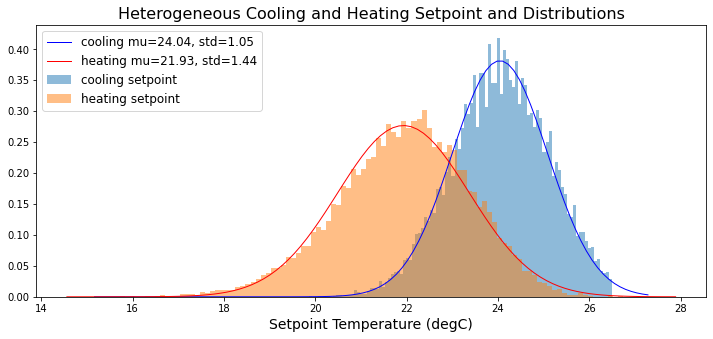

In [22]:
# Plot the distributions
from collections import Counter
from scipy.stats import norm

# Cleanup the data for visualization
c_heating = Counter(ls_heating_setpoints)
c_cooling = Counter(ls_cooling_setpoints)
heating_to_drop = [tup[0] for tup in c_heating.most_common(12)]
heating_setpoints = [val for val in ls_heating_setpoints if val not in heating_to_drop]
cooling_to_drop = [tup[0] for tup in c_cooling.most_common(27)]
cooling_setpoints = [val for val in ls_cooling_setpoints if val not in cooling_to_drop]


# Plot
plt.figure(figsize=(12, 5))
plt.hist(cooling_setpoints, bins=100, density=True, alpha=0.5, label="cooling setpoint")
plt.hist(heating_setpoints, bins=100, density=True, alpha=0.5, label="heating setpoint")

mu_cooling, std_cooling = norm.fit(cooling_setpoints)
xmin_cooling, xmax_cooling = plt.xlim()
x_cooling = np.linspace(xmin_cooling, xmax_cooling, 100)
p_cooling = norm.pdf(x_cooling, mu_cooling, std_cooling)
plt.plot(x_cooling, p_cooling, 'b', linewidth=1, label=f"cooling mu={round(mu_cooling, 2)}, std={round(std_cooling, 2)}")

mu_heating, std_heating = norm.fit(heating_setpoints)
xmin_heating, xmax_heating = plt.xlim()
x_heating = np.linspace(xmin_heating, xmax_heating, 100)
p_heating = norm.pdf(x_heating, mu_heating, std_heating)
plt.plot(x_heating, p_heating, 'r', linewidth=1, label=f"heating mu={round(mu_heating, 2)}, std={round(std_heating, 2)}")
plt.legend(loc="upper left", prop={'size': 12})
plt.xlabel('Setpoint Temperature (degC)', size=14)
plt.title('Heterogeneous Cooling and Heating Setpoint and Distributions', size=16)

# plt.savefig('setpoint distributions.png', dpi=600)

####  Site energy vs other variables scatter plot

In [24]:
# Get all time-series data
df_all = pd.concat([
    get_ts_data(hdf, str_clm = '1A', str_eff = 'Low', str_yr = 'TMY3', str_run = 'run_1'),
    get_ts_data(hdf, str_clm = '1A', str_eff = 'Standard', str_yr = 'TMY3', str_run = 'run_1'),
    get_ts_data(hdf, str_clm = '1A', str_eff = 'High', str_yr = 'TMY3', str_run = 'run_1'),
    get_ts_data(hdf, str_clm = '3C', str_eff = 'Low', str_yr = 'TMY3', str_run = 'run_1'),
    get_ts_data(hdf, str_clm = '3C', str_eff = 'Standard', str_yr = 'TMY3', str_run = 'run_1'),
    get_ts_data(hdf, str_clm = '3C', str_eff = 'High', str_yr = 'TMY3', str_run = 'run_1'),
    get_ts_data(hdf, str_clm = '5A', str_eff = 'Low', str_yr = 'TMY3', str_run = 'run_1'),
    get_ts_data(hdf, str_clm = '5A', str_eff = 'Standard', str_yr = 'TMY3', str_run = 'run_1'),
    get_ts_data(hdf, str_clm = '5A', str_eff = 'High', str_yr = 'TMY3', str_run = 'run_1'),
], axis=0)

<Figure size 432x288 with 0 Axes>

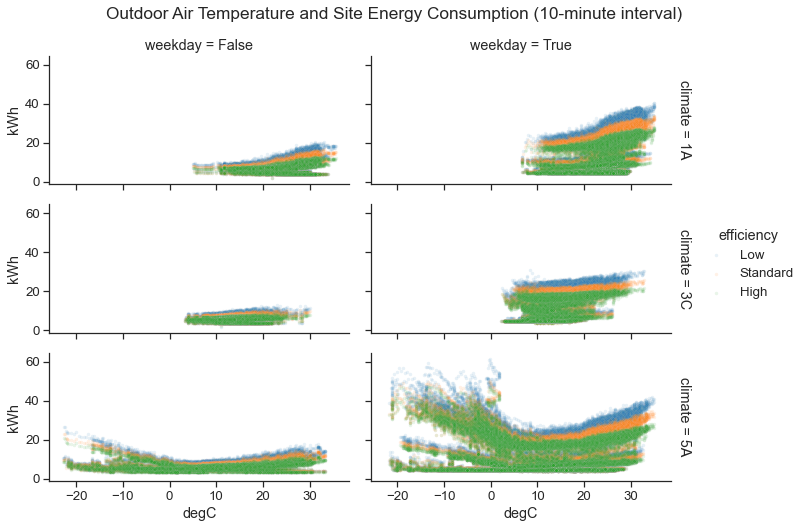

In [25]:
# Plot the outdoor air temperaure vs site energy use intensity scatters

sns.set(font_scale=1.2)
sns.set_style("ticks")
sns.set_palette("tab10")
sns.despine()
g = sns.FacetGrid(df_all, row="climate", col="weekday", hue="efficiency", 
                  margin_titles=True, height=2.5, aspect=2,
                  sharex=True, sharey=True)
g.map(sns.scatterplot, "Outdoor Air Temperature (degC)", "Site Total Energy (kWh)", x_jitter=.1, s=12, alpha=0.1)
# g.map(sns.scatterplot, "Outdoor Air Temperature (degC)", "Site Electricity (kWh)", x_jitter=.1)

g.set_axis_labels("degC", "kWh")
plt.subplots_adjust(top=0.89)
g.fig.suptitle('Outdoor Air Temperature and Site Energy Consumption (10-minute interval)') # can also get the figure from plt.gcf()
g.add_legend()
g.savefig('OAT vs Site Energy.png', dpi=600)

<Figure size 432x288 with 0 Axes>

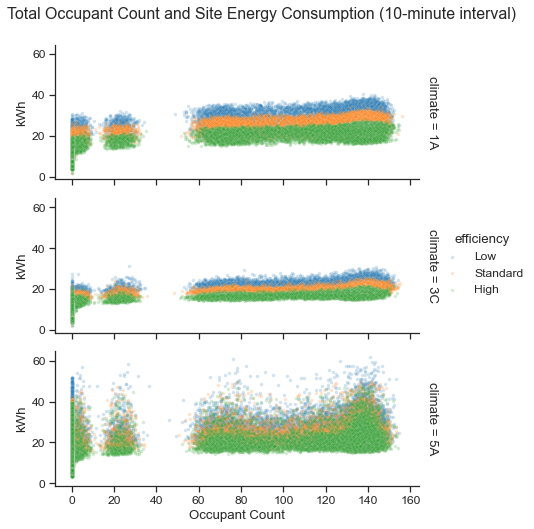

In [26]:
# Plot the occupant count vs site energy use intensity scatters

sns.set(font_scale=1.1)
sns.set_style("ticks")
sns.set_palette("tab10")
sns.despine()
g = sns.FacetGrid(df_all, row="climate", hue="efficiency", 
                  margin_titles=True, height=2.5, aspect=2.5,
                  sharex=True, sharey=True)
# g.map(sns.scatterplot, "Total Occupant Count", "Interior Lighting (kWh)", x_jitter=.1, s=12, alpha=0.2)
g.map(sns.scatterplot, "Total Occupant Count", "Site Total Energy (kWh)", x_jitter=.1, s=12, alpha=0.2)

g.set_axis_labels("Occupant Count", "kWh")
plt.subplots_adjust(top=0.91)
g.fig.suptitle('Total Occupant Count and Site Energy Consumption (10-minute interval)') # can also get the figure from plt.gcf()
g.add_legend()
g.savefig('Occupant Count vs Site Energy.png', dpi=600)